In [ ]:
# Pass an image through the encoder.
# For each axis, get a set of images where the value along the axis is varied according to the assumed prior by
# passing the varied embeddings through the decoder.

# Load the data

In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


In [2]:
# Will pass image(s) into encoder
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=32,
                   distance_threshold=64,
                   crop_mode='resize')

    print('Done creating Track objects.')

2022-10-11 07:58:25.515745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 07:58:26.183872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:48<00:00,  4.04s/it]


Done creating Track objects.


# Load model

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [4]:
# Load the model
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [5]:
model_name = 'simple'
vae = VAE(16, 1, 1e-3, 64, 4, 32)
AE = vae.build_vae_keras_model()
AE.load_weights('/data/models/' + model_name)

2022-10-11 08:02:31.955776: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Get reconstructions

In [6]:
# First, let's get the reconstruction of 'rep' itself

In [7]:
def get_embedding(img, encoder):
    rep = encoder(np.array([img])).mean()
    return rep[0]

In [8]:
def get_recon(rep, decoder):
    recon = decoder(np.array([rep])).mean()
    return recon[0]

In [9]:
def get_axis_travs(axis, rep):
    # rep will be a tf.Tensor
    axis_travs = []
    for std in range(-3, 4):
        mod_rep = np.array(rep)
        mod_rep[axis] = std
        axis_travs.append(tf.convert_to_tensor(mod_rep, dtype='float32'))
    return axis_travs

In [10]:
encoder = AE.get_layer('encoder')
decoder = AE.get_layer('decoder')
img = val_tracks.appearances[2][13][6]

In [11]:
rep = get_embedding(img, encoder)

2022-10-11 08:02:35.330237: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [12]:
rep

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([   184.31772,   -911.5647 ,  -1586.2957 ,  -3886.691  ,
         -375.40326,    714.1629 ,  37615.84   ,   -477.32513,
          621.1263 ,   -957.10486, -19220.498  ,   1458.6959 ,
        -1297.1034 , -23454.291  ,  57265.277  ,   3765.2036 ],
      dtype=float32)>

In [13]:
recon = get_recon(rep, decoder)

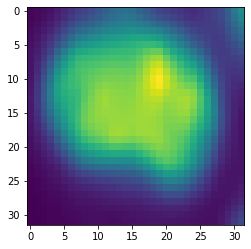

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(img)

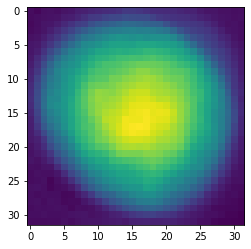

In [16]:
fig, ax = plt.subplots()
ax.imshow(recon)

In [17]:
encoder(np.array([img])).mean()

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[   184.31772,   -911.5647 ,  -1586.2957 ,  -3886.691  ,
          -375.40326,    714.1629 ,  37615.84   ,   -477.32513,
           621.1263 ,   -957.10486, -19220.498  ,   1458.6959 ,
         -1297.1034 , -23454.291  ,  57265.277  ,   3765.2036 ]],
      dtype=float32)>

In [18]:
encoder(np.array([img])).stddev()

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[3091.4011, 3438.4968, 2641.733 , 3992.7573, 5659.407 ,    0.    ,
           0.    , 3129.282 , 6465.4697, 2148.119 ,    0.    , 3766.3203,
           0.    ,    0.    ,    0.    ,    0.    ]], dtype=float32)>

In [19]:
def get_life_cycle_dict(tracks):
    batches, frames, cells = tracks.centroids.shape[:3]
    
    life_cycle_dict = {}
    for batch in range(batches):
        life_cycle_dict[batch] = {}
        for cell in range(cells):
            life_cycle_dict[batch][cell] = {}
            for frame in range(frames):
                life_cycle_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in tracks.lineages[batch].keys():
            if len(tracks.lineages[batch][cell]['daughters']) != 0:
                cell_frames = tracks.lineages[batch][cell]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    life_cycle_dict[batch][cell - 1][cell_frame] = last_frame - cell_frame + 1
    
    return life_cycle_dict

In [20]:
val_life_cycle_dict = get_life_cycle_dict(val_tracks)

In [21]:
val_life_cycle_dict[0]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  3

In [22]:
val_tracks.appearances.shape

(27, 71, 277, 32, 32, 1)

In [23]:
val_life_cycle_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [24]:
val_life_cycle_dict[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [25]:
val_life_cycle_dict[0][0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

In [27]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d

In [28]:
val_good_imgs = load_img_dict('/data/dataset_pruning/val_appearances_dict.json')

In [29]:
val_good_imgs[0]

{0: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: -1,
  5: -1,
  6: -1,
  7: -1,
  8: -1,
  9: -1,
  10: -1,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,
  31: -1,
  32: -1,
  33: -1,
  34: -1,
  35: -1,
  36: -1,
  37: -1,
  38: -1,
  39: -1,
  40: -1,
  41: -1,
  42: -1,
  43: -1,
  44: -1,
  45: -1,
  46: -1,
  47: -1,
  48: -1,
  49: -1,
  50: -1,
  51: -1,
  52: -1,
  53: -1,
  54: -1,
  55: -1,
  56: -1,
  57: -1,
  58: -1,
  59: -1,
  60: -1,
  61: -1,
  62: -1,
  63: -1,
  64: -1,
  65: -1,
  66: -1,
  67: -1,
  68: -1,
  69: -1,
  70: -1},
 1: {0: -1,
  1: -1,
  2: -1,
  3: -1,
  4: 0,
  5: 1,
  6: 2,
  7: 3,
  8: 4,
  9: 5,
  10: 6,
  11: -1,
  12: -1,
  13: -1,
  14: -1,
  15: -1,
  16: -1,
  17: -1,
  18: -1,
  19: -1,
  20: -1,
  21: -1,
  22: -1,
  23: -1,
  24: -1,
  25: -1,
  26: -1,
  27: -1,
  28: -1,
  29: -1,
  30: -1,


In [30]:
val_good_imgs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [31]:
val_good_imgs[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [32]:
val_good_imgs[0][0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

In [54]:
import pandas as pd
from keras import backend as K

# Gets embeddings of each array (train, val) along with frame classes
# app is probably like val_tracks.appearances

# tracks.appearances and life_cycle_dict are both 0-indexed along every axis
# but life_cycle_dict is batch, cell, frame
def get_embeddings_df(tracks, encoder, embedding_dim):
    app = tracks.appearances
    life_cycle_dict = get_life_cycle_dict(tracks)
    
    batches, frames, cells = app.shape[0], app.shape[1], app.shape[2]
    
    embeddings_lst = []
    for b in range(batches):
        print(b)
        for f in range(frames):
            for c in range(cells):
                img = app[b][f][c]
                embedding = get_embedding(img, encoder)
                label = life_cycle_dict[b][c][f]
                embeddings_lst.append(np.append(embedding, label))
    
    cols = [idx for idx in range(2 * embedding_dim)]
    cols.append('Frames to Split')
    embeddings_df = pd.DataFrame(embeddings_lst, columns=cols)
    return embeddings_df

In [55]:
embeddings_df = get_embeddings_df(val_tracks, encoder, 16)

0


KeyboardInterrupt: 

In [54]:
%%time
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/data/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    print("All " + str(len(all_val_data)) + " trks are loaded")
    
    all_val_tracks = [Track(tracked_data=d, appearance_dim=32, crop_mode='resize') for d in all_val_data]
    print("converted to Track objects")
    
    val_track_info = concat_tracks(all_val_tracks)

All 1 trks are loaded


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:49<00:00,  4.04s/it]


converted to Track objects
CPU times: user 15min 59s, sys: 19min 42s, total: 35min 41s
Wall time: 4min 44s


In [55]:
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    good_img_list.append(app[batch][frame][cell])
    appearances = np.array(good_img_list)
    return appearances

In [58]:
with tf.device('/device:CPU:0'):
    val_appearances = get_good_img_arr(val_good_imgs, val_track_info['appearances'])

In [90]:
val_track_info['appearances'].shape

(27, 71, 277, 32, 32, 1)

In [92]:
val_tracks.appearances.shape

(27, 71, 277, 32, 32, 1)

In [59]:
val_appearances.shape

(89436, 32, 32, 1)

In [44]:
val_track_info.keys()

dict_keys(['appearances', 'centroids', 'morphologies', 'adj_matrices', 'norm_adj_matrices', 'temporal_adj_matrices'])

In [46]:
type(val_tracks.morphologies)

numpy.ndarray

In [62]:
val_appearances[2][13][6].shape

(1,)

In [63]:
img = val_appearances[0]

In [64]:
rep = get_embedding(img, encoder)

In [65]:
rep

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([  1137.3964 ,    625.12085,   -412.92114,  -2223.2192 ,
         -684.1508 ,   -293.74185,  43003.465  ,    574.2793 ,
        -1084.0016 ,    209.21448,  -4220.1523 ,   1566.8766 ,
        34814.39   , -24884.605  ,  73668.26   ,  -9525.054  ],
      dtype=float32)>

In [ ]:
# The get_embedding function works regardless of whether the image comes from tracks.appearances or appearances.
# We just need to use good_imgs to make sure we are only getting embeddings for... good images (appearances, on the
# other hand, only has good images) and use life_cycle_dict to get the number of frames to split.

In [68]:
import pandas as pd
from keras import backend as K

# Gets embeddings of each array (train, val) along with frame classes
# app is probably like val_tracks.appearances

# tracks.appearances and life_cycle_dict are both 0-indexed along every axis
# but life_cycle_dict is batch, cell, frame
def get_embeddings_df(tracks, encoder, embedding_dim, good_imgs):
    app = tracks.appearances
    life_cycle_dict = get_life_cycle_dict(tracks)
    
    batches, frames, cells = app.shape[0], app.shape[1], app.shape[2]
    
    embeddings_lst = []
    for b in range(batches):
        print(b)
        for f in range(frames):
            for c in range(cells):
                if good_imgs[b][c][f] != -1:
                    img = app[b][f][c]
                    embedding = get_embedding(img, encoder)
                    label = life_cycle_dict[b][c][f]
                    embeddings_lst.append(np.append(embedding, label))
    
    cols = [idx for idx in range(embedding_dim)]
    cols.append('Frames to Split')
    embeddings_df = pd.DataFrame(embeddings_lst, columns=cols)
    return embeddings_df

In [69]:
val_embeddings_df = get_embeddings_df(val_tracks, encoder, 16, val_good_imgs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [112]:
val_embeddings_df[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Frames to Split
0,1046.447632,-2154.603760,-2181.941650,-8822.098633,306.345032,3994.729736,65883.476562,-1933.147949,5097.046875,-3135.754395,-28361.572266,4816.504395,-5823.185059,-39425.332031,144509.203125,-42520.664062,5.0
1,352.286957,592.111084,-1629.294189,-3279.268066,-246.443665,1647.438843,42363.550781,-18.869017,681.621277,-670.043335,6066.872070,2309.933105,-9788.114258,-13584.905273,65645.101562,-33091.000000,-1.0
2,-92.168427,-77.919708,370.839417,-704.555603,92.206223,-434.603058,5884.356445,-312.292572,66.406296,257.837036,682.428711,489.737976,1045.523926,-9910.558594,4942.546875,2355.809814,-1.0
3,279.255219,-297.603790,-2176.823975,-3699.546387,484.682312,1668.305542,34011.371094,-324.098694,1325.930176,-443.180054,2400.801270,1828.935181,-5608.181152,-15826.920898,65692.640625,-20369.931641,-1.0
4,9.684422,-350.076447,-1.023198,-1294.536133,-752.942871,502.775726,19737.423828,-338.815765,73.082199,-989.216675,-3219.111328,706.418518,-3193.927002,-10119.467773,15301.776367,-5790.764648,-1.0


In [107]:
# Count number of images for which we have data on frames to split
# val_embeddings_df[col][idx]
splitting = 0
not_splitting = 0
no_info = 0
num = 0
for t in val_embeddings_df['Frames to Split']:
    num += 1
    if t <= 5 and t > -1:
        splitting += 1
    if t > 5:
        not_splitting += 1
    if t == -1:
        no_info += 1

In [108]:
print(splitting, not_splitting, no_info, splitting + not_splitting + no_info, num)

1951 9224 78261 89436 89436


In [104]:
print(val_embeddings_df['Frames to Split'][2])

-1.0


In [110]:
just_val_embeddings_df = val_embeddings_df.drop('Frames to Split', axis=1)

In [111]:
just_val_embeddings_df[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1046.447632,-2154.603760,-2181.941650,-8822.098633,306.345032,3994.729736,65883.476562,-1933.147949,5097.046875,-3135.754395,-28361.572266,4816.504395,-5823.185059,-39425.332031,144509.203125,-42520.664062
1,352.286957,592.111084,-1629.294189,-3279.268066,-246.443665,1647.438843,42363.550781,-18.869017,681.621277,-670.043335,6066.872070,2309.933105,-9788.114258,-13584.905273,65645.101562,-33091.000000
2,-92.168427,-77.919708,370.839417,-704.555603,92.206223,-434.603058,5884.356445,-312.292572,66.406296,257.837036,682.428711,489.737976,1045.523926,-9910.558594,4942.546875,2355.809814
3,279.255219,-297.603790,-2176.823975,-3699.546387,484.682312,1668.305542,34011.371094,-324.098694,1325.930176,-443.180054,2400.801270,1828.935181,-5608.181152,-15826.920898,65692.640625,-20369.931641
4,9.684422,-350.076447,-1.023198,-1294.536133,-752.942871,502.775726,19737.423828,-338.815765,73.082199,-989.216675,-3219.111328,706.418518,-3193.927002,-10119.467773,15301.776367,-5790.764648


In [113]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [116]:
def project_embeddings_tsne(embeddings_df, tsne):
    just_embeddings_df = embeddings_df.drop('Frames to Split', axis=1)
    viz_embeddings = tsne.fit_transform(just_embeddings_df)
    viz_embeddings_df = pd.DataFrame(data = viz_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([viz_embeddings_df, embeddings_df[['Frames to Split']]], axis = 1)
                          
    return final_df

In [117]:
%%time
val_embeddings_tsne_df = project_embeddings_tsne(val_embeddings_df, tsne)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 41min 8s, sys: 21.3 s, total: 41min 29s
Wall time: 4min 30s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


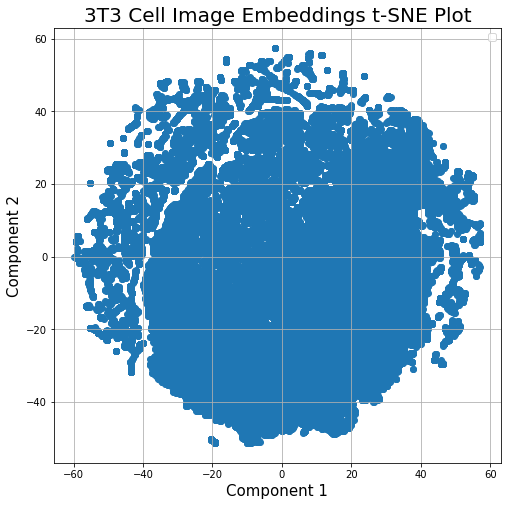

In [118]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(val_embeddings_tsne_df['component 1'], val_embeddings_tsne_df['component 2'])
ax.legend()
ax.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


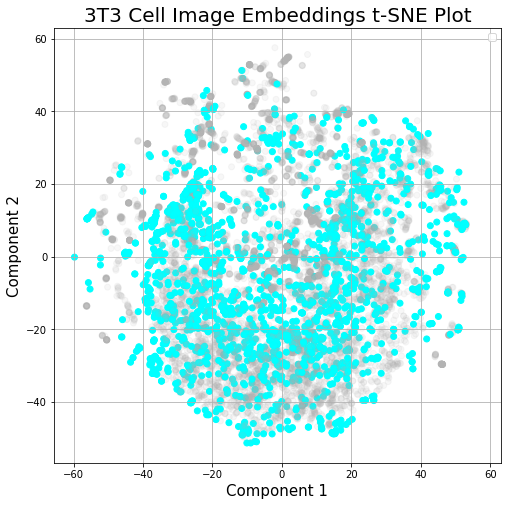

In [128]:
colors = []
opacity = []
for time in val_embeddings_tsne_df['Frames to Split']:
    if time == -1:
        colors.append((1, 1, 1))
        opacity.append(0)
    elif time <= 5:
        colors.append((0, 1, 1))
        opacity.append(1)
    elif time > 5:
        colors.append((0.7, 0.7, 0.7))
        opacity.append(0.1)
        

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(val_embeddings_tsne_df['component 1'], val_embeddings_tsne_df['component 2'], alpha = opacity, c = colors)
ax.legend()
ax.grid()

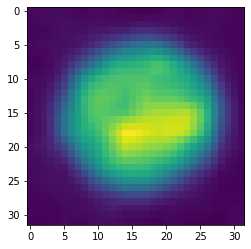

In [141]:
img = val_tracks.appearances[10][13][20]
fig, ax = plt.subplots()
ax.imshow(img)

In [142]:
rep = get_embedding(img, encoder)
recon = get_recon(rep, decoder)

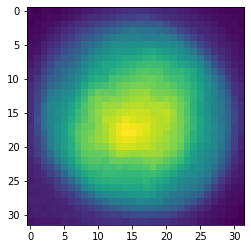

In [143]:
fig, ax = plt.subplots()
ax.imshow(recon)